# Exponentially autocorrelated time series

Obtained from a simple ARMA process

- arma statsmodel [doc](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.arma_generate_sample.html#statsmodels.tsa.arima_process.arma_generate_sample)
- arma on [wikipedia](https://en.wikipedia.org/wiki/Autoregressive–moving-average_model)

In [1]:
import numpy as np
import xarray as xr
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt

import sstats.tseries as ts
import sstats.sigp as sigp

In [2]:
from dask.distributed import Client, LocalCluster

#
cluster = LocalCluster()
#
# from dask_jobqueue import PBSCluster
# cluster = PBSCluster()
# w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:61366 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


---

## generate synthetic data

In [3]:
?ts.exp_autocorr

Signature: ts.exp_autocorr(time, T, rms, draws=1, dummy_dims=None, **kwargs)
Docstring:
Generate exponentially correlated time series
Implemented via ARMA
x_{t} = x_{t-1} * (1-dt/T) + \sqrt{2*dt/T}*rms *e_t

Sawford 1991

Parameters:
-----------
time: int, np.ndarray, tuple
    Number of time steps, time array, tuple (T, dt)
T: float, iterable
    Decorrelation time scales
rms: float, iterable
    Desired rms (not exact for each realization)
draws: int, optional
    Size of the ensemble, default to 1
seed: int, optional
    numpy seed
File:      ~/Code/synthetic_stats/sstats/tseries.py
Type:      function


In [4]:
# x = (ts.exp_autocorr((1000, 1./24), np.arange(10,30,10), 1, draws=100)
x = (
    ts.exp_autocorr((1000, 1.0 / 24), np.arange(10, 100, 10), 1, draws=100)
    .rename("x")
    .transpose("T", "draw", "time")
    .persist()
)
x

<xarray.DataArray 'x' (T: 9, draw: 100, time: 24000)>
dask.array<transpose, shape=(9, 100, 24000), dtype=float64, chunksize=(9, 50, 24000), chunktype=numpy.ndarray>
Coordinates:
  * T        (T) int64 10 20 30 40 50 60 70 80 90
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Attributes:
    rms:      1

### time series overview

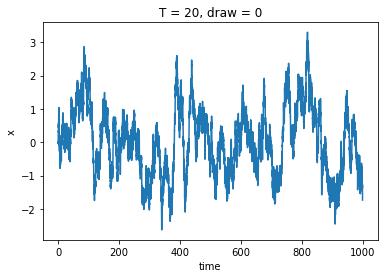

In [5]:
_x = x.sel(draw=0, T=20)
_x.plot()

### autocorrelation with sm

see [doc](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)

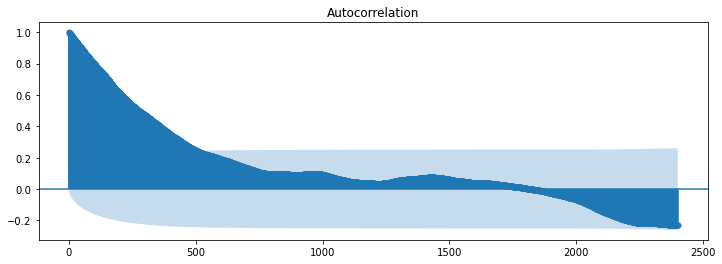

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
fig = sm.graphics.tsa.plot_acf(_x.squeeze(), lags=100 * 24, ax=ax)

### autocorrelation over whole dataset

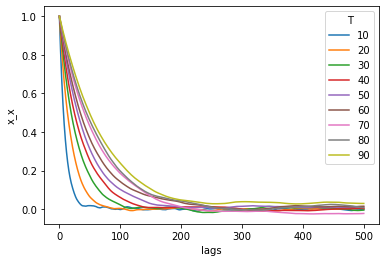

In [8]:
xx = sigp.correlate(x, x).persist()
_ = (xx / xx.sel(lags=0)).mean("draw").plot.line(x="lags")

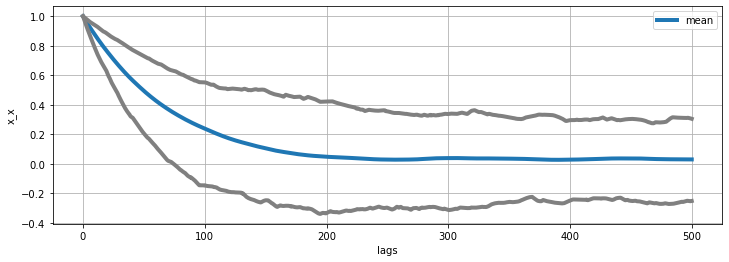

In [10]:
# focus on largest lag
def plot_correlation(_xx):
    _xx = _xx / _xx.sel(lags=0)
    mean = _xx.mean("draw")
    quantiles = [0.05, 0.95]
    qt = _xx.chunk(-1).quantile(q=quantiles, dim="draw").persist()

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    mean.plot.line(x="lags", lw=4, add_legend=False, label="mean")
    qt.plot.line(x="lags", lw=4, color=".5")
    ax.grid()
    ax.legend()


plot_correlation(_xx=xx.isel(T=-1))

---
## test sensibility to trend

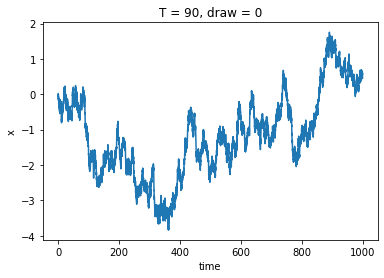

In [11]:
_x = x.sel(draw=0).isel(T=-1)
_x.plot()

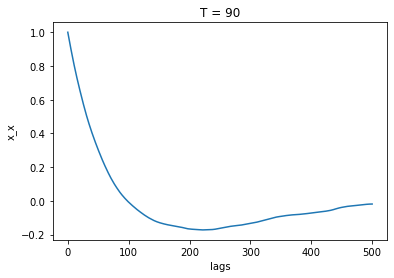

In [15]:
# with detrending
xx_detrend = sigp.correlate(x.isel(T=-1), x.isel(T=-1), detrend=True).persist()
_ = (xx_detrend / xx_detrend.sel(lags=0)).mean("draw").plot.line(x="lags")

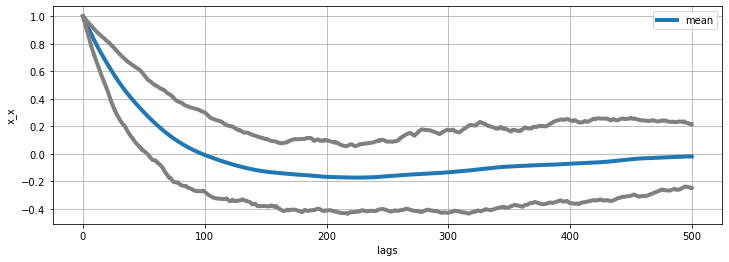

In [16]:
# focus on largest lag
plot_correlation(xx_detrend)